# DomainMapCycleGAN

unsupervised cross subjects domain adaptation for human activity recognition

In [0]:
# to use Conv1DTranspose later
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1DTranspose
!pip install tf-nightly

In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

import os
import time

print(tf.__version__)

2.3.0-dev20200524


## Dataset

We use HCI HAR dataset. For more information about this dataset, you can click [Human Activity Recognition Using Smartphones Data Set, UCI Machine Learning Repository](https://link.springer.com/chapter/10.1007/978-3-642-35395-6_30)

In [0]:
# download dataset
_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'

path_to_zip = tf.keras.utils.get_file('HARDataset.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'UCI HAR Dataset/')

### Load data

In [0]:
def load_file(filepath):
    '''
    load a single file as a numpy array
    '''
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames):
    '''
    load a list of files into a 3D array of [samples, timesteps, features]
    '''
    loaded = list()
    for name in filenames:
        data = load_file(name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset(train_dir_path, test_dir_path):
    '''
    load dataset as train and test
    '''
    files_prefix = ['total_acc_x_', 'total_acc_y_', 'total_acc_z_', 'body_acc_x_',
                    'body_acc_y_', 'body_acc_z_', 'body_gyro_x_', 'body_gyro_y_', 'body_gyro_z_']

    train_files = [train_dir_path + 'Inertial Signals/' + pre + 'train.txt' for pre in files_prefix]
    test_files = [test_dir_path + 'Inertial Signals/' + pre + 'test.txt' for pre in files_prefix]

    train_X = load_group(train_files)
    train_y = load_file(train_dir_path + 'y_train.txt')

    test_X = load_group(test_files)
    test_y = load_file(test_dir_path + 'y_test.txt')

    return train_X, train_y, test_X, test_y

def scale_data(X):
    '''
    scale data to [-1, 1]
    '''
    scaled = X / abs(X).max()
    return scaled

def scale_dataset(dataset):
    scaled = []
    for i in range(dataset.shape[-1]):
        scaled.append(scale_data(dataset[..., i]))
    return np.dstack(scaled)

def data_for_subject(X, y, sub_map, sub_id):
    '''
    get add data for one subject
    '''
    xi = [i for i in range(len(sub_map)) if sub_map[i] == sub_id]
    return X[xi], y[xi]

def to_series(windows):
    '''
    remove overlap and convert a series of continuous windows to a 1D list
    '''
    series = []
    n, win_size = windows.shape
    series += list(windows[0][:win_size // 2])
    for i in range(n):
        series += list(windows[i][win_size // 2:])
    return series

Load train data and test test

In [0]:
train_X, train_y, test_X, test_y = load_dataset(PATH + 'train/', PATH + 'test/')

# zero-offset class values
train_y -= 1
test_y -= 1

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


From `README.txt` file in the dataset folder:

The following files are available for the train and test data. Their descriptions are equivalent. 

- 'train/subject_train.txt': Each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30. 

In [0]:
sub_map = load_file(PATH + 'train/subject_train.txt')

train_subjects = np.unique(sub_map)
print(train_subjects)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


Prepare 2 different subjects data (**source domain** and **target domain**).

Before feed to model, we should scale data to range [-1, 1].

> Although it is said in `README.txt` of the dataset folder: *Features are normalized and bounded within [-1,1].* I found data is actually not in this range. So we need to scale data.

In [0]:
# subject 1 as source domain
source_subject_X, source_subject_y = data_for_subject(train_X, train_y, sub_map, train_subjects[0])
# subject 5 as target domain
target_subject_X, target_subject_y = data_for_subject(train_X, train_y, sub_map, train_subjects[2])

# scale to [-1, 1]
source_subject_X = scale_dataset(source_subject_X)
target_subject_X = scale_dataset(target_subject_X)

print(source_subject_X.shape, source_subject_X.shape)
print(target_subject_X.shape, target_subject_X.shape)

(347, 128, 9) (347, 128, 9)
(302, 128, 9) (302, 128, 9)


### Analyze data

In [0]:
def plot_window(window, fig_title='window'):
    '''
    plot the data in a window
    '''
    fig = plt.figure()
    n = window.shape[-1]

    axis = ['x', 'y', 'z']
    title = ['total acc ' + i for i in axis] + ['body acc ' +
                                                i for i in axis] + ['body gyro ' + i for i in axis]
    for i in range(n):
        ax = fig.add_subplot(n, 1, i+1)
        ax.plot(window[:,i], 'r')
        ax.xaxis.set_visible(False)
        ax.set_ylim([-1.0, 1.0])
        # ax.set_title(title[i])
    
    fig.suptitle(fig_title)

    plt.show()
    
def class_breakdown(data):
    '''
    summarize the balance of classes
    '''
    # activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
    df = pd.DataFrame(data)
    df[0].value_counts().plot(kind='bar', title='Acticity')
    plt.show()

def plot_subject(X, y):
    '''
    plot the data for a single subject
    '''
    fig = plt.figure(figsize=(10, 20))
    n = X.shape[2] + 1
    axis = ['x', 'y', 'z']
    title = ['total acc ' + i for i in axis] + ['body acc ' +
                                                i for i in axis] + ['body gyro ' + i for i in axis]
    for i in range(n-1):
        ax = fig.add_subplot(n, 1, i + 1)
        series = to_series(X[..., i])
        ax.plot(series, 'r')
        ax.set_title(title[i])
        ax.xaxis.set_visible(False)
        ax.set_ylim([min(series) - np.std(series), max(series) + np.std(series)])
        ax.grid(True)

    ax = fig.add_subplot(n, 1, n)
    ax.plot(y, 'g')
    ax.set_title('activity')
    
    plt.subplots_adjust(hspace=0.2)
    plt.show()

count each class instance

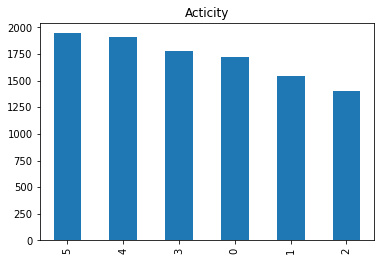

In [0]:
class_breakdown(np.vstack((train_y, test_y)))

plot source subject domain and target subject domain

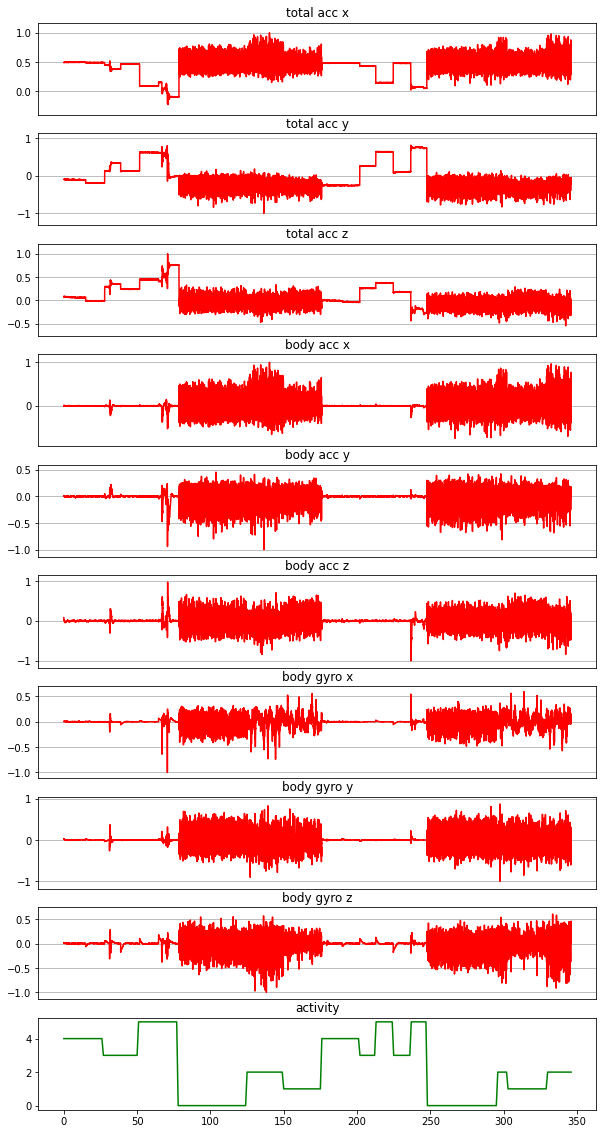

In [0]:
plot_subject(source_subject_X, source_subject_y)

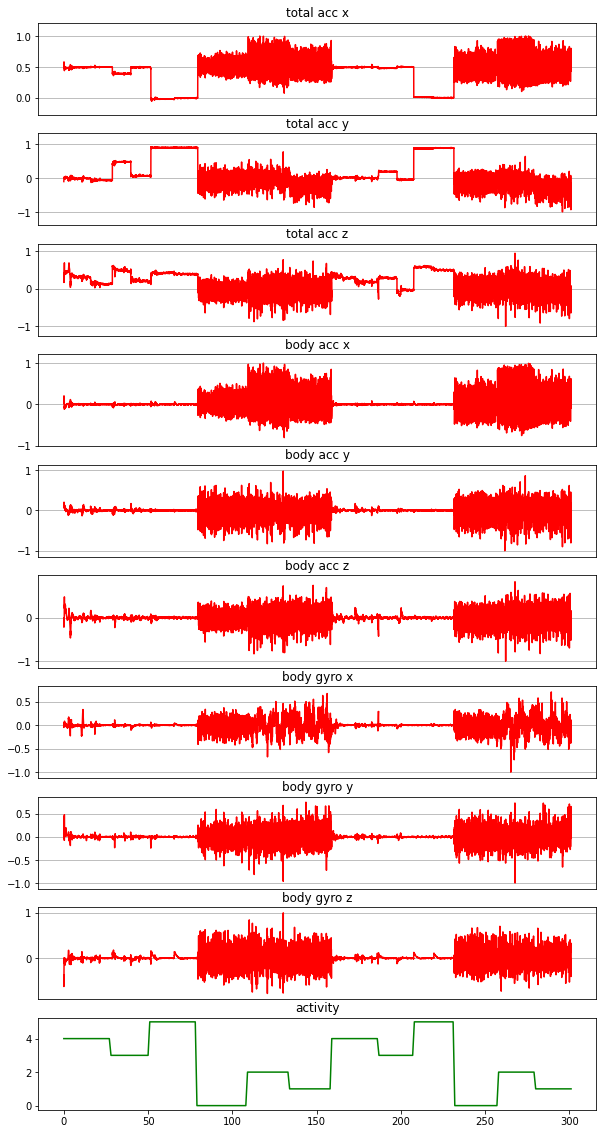

In [0]:
plot_subject(target_subject_X, target_subject_y)

plot a single window from source subject

(128, 9)


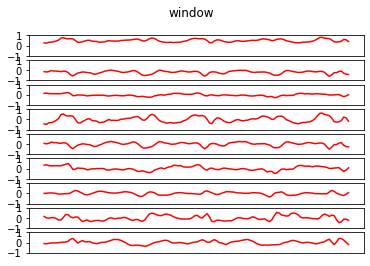

In [0]:
source_sample_window = source_subject_X[100]
print(source_sample_window.shape)
plot_window(source_sample_window)

## Classifier model

Use a multi-layers CNN as classifier

In [0]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

# Number filters convolutional layers
NUM_FILTERS = 64

# Size filters convolutional layers
FILTER_SIZE = 5

# Number of unit in the long short-term recurrent layers
NUM_UNITS_LSTM = 128


def deepConvLSTM(input_shape=(128, 9), num_classes=6):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        Conv1D(NUM_FILTERS, FILTER_SIZE, activation='relu'),
        Conv1D(NUM_FILTERS, FILTER_SIZE, activation='relu'),
        Conv1D(NUM_FILTERS, FILTER_SIZE, activation='relu'),
        Conv1D(NUM_FILTERS, FILTER_SIZE, activation='relu'),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])
    return model

train classifier using target subject

In [0]:
subject_classifier_model = deepConvLSTM()
subject_classifier_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
subject_classifier_model.fit(target_subject_X, target_subject_y, validation_split=0.3, epochs=100, batch_size=50, validation_freq=10)
subject_classifier_model.evaluate(source_subject_X, source_subject_y, batch_size=50)

Epoch 1/100
5/5 [==============================] - 0s 7ms/step - loss: 1.7721 - accuracy: 0.3033
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 1.5663 - accuracy: 0.4739
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 1.4293 - accuracy: 0.6114
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 1.3124 - accuracy: 0.7441
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 1.2939 - accuracy: 0.7678
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 1.2515 - accuracy: 0.7915
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 1.1733 - accuracy: 0.8910
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 1.1907 - accuracy: 0.8673
Epoch 9/100
5/5 [==============================] - 0s 6ms/step - loss: 1.1600 - accuracy: 0.8815
Epoch 10/100
5/5 [==============================] - 0s 47ms/step - loss: 1.1112 - accuracy: 0.9479 - val_loss: 1.1938 - val_acc

[1.5473302602767944, 0.49567723274230957]

## CycleGAN

In [0]:
class InstanceNormalization(tf.keras.layers.Layer):
    """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    down_result = tf.keras.Sequential()
    down_result.add(
        tf.keras.layers.Conv1D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)
    )

    if apply_instancenorm:
        down_result.add(InstanceNormalization())

    down_result.add(tf.keras.layers.LeakyReLU())

    return down_result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    up_result = tf.keras.Sequential()

    # Conv1DTranspose is now only available in tf-nighty
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1DTranspose
    up_result.add(tf.keras.layers.Conv1DTranspose(
        filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    up_result.add(InstanceNormalization())

    if apply_dropout:
        up_result.add(tf.keras.layers.Dropout(0.5))

    up_result.add(tf.keras.layers.ReLU())

    return up_result

def resnet_block(filters, size, input_layer):
    initializer = tf.random_normal_initializer(0., 0.02)
    # first layer convolutional layer
    g = tf.keras.layers.Conv1D(filters, size, padding='same', kernel_initializer=initializer)(input_layer)
    g = InstanceNormalization()(g)
    g = tf.keras.layers.Activation('relu')(g)
    # second cnn
    g = tf.keras.layers.Conv1D(filters, size, padding='same', kernel_initializer=initializer)(g)
    g = InstanceNormalization()(g)
    g = tf.keras.layers.Concatenate()([g, input_layer])
    return g

In [0]:
def Generator(input_shape=(128, 9), output_channels=9):
    inputs = tf.keras.layers.Input(shape=input_shape)

    down_stack = [
        downsample(8, 5, apply_instancenorm=False),  # (bs, 64, 8)
        downsample(16, 5),  # (bs, 32, 16)
        downsample(32, 5),  # (bs, 16, 32)
        downsample(32, 5),  # (bs, 8, 32)   
    ]

    up_stack = [
        upsample(32, 5, apply_dropout=True),  # (bs, 16, 64)
        upsample(16, 5),  # (bs, 32, 32)
        upsample(8, 5),  # (bs, 64, 16)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv1DTranspose(
        output_channels, 5, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # (bs, 128, 9)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    x = resnet_block(32, 5, input_layer=x)
    x = resnet_block(32, 5, input_layer=x)
    x = resnet_block(32, 5, input_layer=x)

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x) 

    return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
def Discriminator(input_shape=(128, 9)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = inputs
    x = downsample(8, 5, apply_instancenorm=False)(x)  # (bs, 64, 8)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = downsample(16, 5)(x)  # (bs, 32, 16)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = downsample(32, 5)(x)  # (bs, 16, 32)
    x = downsample(32, 5)(x)  # (bs, 8, 32)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

define 2 generator and 2 discriminator for cyclegan

In [0]:
generator_s2t = Generator(input_shape=(128, 9), output_channels=9)
generator_t2s = Generator(input_shape=(128, 9), output_channels=9)

discriminator_s = Discriminator(input_shape=(128, 9))
discriminator_t = Discriminator(input_shape=(128, 9))

define loss function

In [0]:
LAMBDA = 10
crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real, disc_generated):
    real_loss = crossentropy(tf.ones_like(disc_real), disc_real)

    generated_loss = crossentropy(
        tf.zeros_like(disc_generated), disc_generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

    
def generator_loss(disc_generated):
    return crossentropy(tf.ones_like(disc_generated), disc_generated)


def calc_cycle_loss(real, cycled):
    loss1 = tf.reduce_mean(tf.abs(real - cycled))

    return LAMBDA * loss1


def identity_loss(real, same):
    loss = tf.reduce_mean(tf.abs(real - same))
    return LAMBDA * 0.5 * loss

In [0]:
generator_s2t_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_t2s_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_s_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_t_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Checkpoints

mount google drive to save checkpoints

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
drive_path = '/content/gdrive/My Drive/'
checkpoint_path = "./checkpoints/dmcyclegan/train"

ckpt_path = drive_path + checkpoint_path

ckpt = tf.train.Checkpoint(generator_s2t=generator_s2t,
                           generator_t2s=generator_t2s,
                           discriminator_s=discriminator_s,
                           discriminator_t=discriminator_t,
                           generator_s2t_optimizer=generator_s2t_optimizer,
                           generator_t2s_optimizer=generator_t2s_optimizer,
                           discriminator_s_optimizer=discriminator_s_optimizer,
                           discriminator_t_optimizer=discriminator_t_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [0]:
import datetime
log_dir='logs/'

summary_writer = tf.summary.create_file_writer(log_dir + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [0]:
@tf.function
def train_step(real_s, real_t, epoch):
    with tf.GradientTape(persistent=True) as tape:
        fake_t = generator_s2t(real_s, training=True)
        cycled_s = generator_t2s(fake_t, training=True)

        fake_s = generator_t2s(real_t, training=True)
        cycled_t = generator_s2t(fake_s, training=True)

        same_s = generator_t2s(real_s, training=True)
        same_t = generator_s2t(real_t, training=True)

        disc_real_s = discriminator_s(real_s, training=True)
        disc_real_t = discriminator_t(real_t, training=True)

        disc_fake_s = discriminator_s(fake_s, training=True)
        disc_fake_t = discriminator_t(fake_t, training=True)

        gen_s2t_loss = generator_loss(disc_fake_t)
        gen_t2s_loss = generator_loss(disc_fake_s)

        total_cycle_loss = calc_cycle_loss(
            real_s, cycled_s) + calc_cycle_loss(real_t, cycled_t)

        total_gen_s2t_loss = gen_s2t_loss + \
            total_cycle_loss + identity_loss(real_t, same_t)
        total_gen_t2s_loss = gen_t2s_loss + \
            total_cycle_loss + identity_loss(real_s, same_s)

        disc_s_loss = discriminator_loss(disc_real_s, disc_fake_s)
        disc_t_loss = discriminator_loss(disc_real_t, disc_fake_t)

    generator_s2t_gradients = tape.gradient(
        total_gen_s2t_loss, generator_s2t.trainable_variables)
    generator_t2s_gradients = tape.gradient(
        total_gen_t2s_loss, generator_t2s.trainable_variables)

    discriminator_s_gradients = tape.gradient(
        disc_s_loss, discriminator_s.trainable_variables)
    discriminator_t_gradients = tape.gradient(
        disc_t_loss, discriminator_t.trainable_variables)

    generator_s2t_optimizer.apply_gradients(
        zip(generator_s2t_gradients, generator_s2t.trainable_variables))

    generator_t2s_optimizer.apply_gradients(
        zip(generator_t2s_gradients, generator_t2s.trainable_variables))

    discriminator_s_optimizer.apply_gradients(
        zip(discriminator_s_gradients, discriminator_s.trainable_variables))

    discriminator_t_optimizer.apply_gradients(
        zip(discriminator_t_gradients, discriminator_t.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_s2t_loss', gen_s2t_loss, step=epoch)
        tf.summary.scalar('gen_t2s_loss', gen_t2s_loss, step=epoch)
        tf.summary.scalar('total_gen_s2t_loss', total_gen_s2t_loss, step=epoch)
        tf.summary.scalar('total_gen_t2s_loss', total_gen_t2s_loss, step=epoch)
        tf.summary.scalar('disc_s_loss', disc_s_loss, step=epoch)
        tf.summary.scalar('disc_t_loss', disc_t_loss, step=epoch)
        tf.summary.scalar('total_cycle_loss', total_cycle_loss, step=epoch)

In [0]:
source_X = tf.data.Dataset.from_tensor_slices(tf.cast(source_subject_X, tf.float32)).batch(1)
target_X = tf.data.Dataset.from_tensor_slices(tf.cast(target_subject_X, tf.float32)).batch(1)

In [0]:
source_sample_window = np.expand_dims(source_sample_window, axis=0)
print(source_sample_window.shape)

(1, 128, 9)


In [0]:
def cmp_win(source_win):
    gen_win = generator_s2t(source_win)
    cycled_win = generator_t2s(gen_win)

    plot_window(source_win[0], fig_title='Original Window')
    plot_window(gen_win[0], fig_title='Generated Window')
    plot_window(cycled_win[0], fig_title='Cycled Window')

In [0]:
def fit(epochs=100):
    for epoch in range(epochs):
        start = time.time()

        n = 0
        for real_s, real_t in tf.data.Dataset.zip((source_X, target_X)):
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            n += 1
            train_step(real_s, real_t, epoch)
        print()
            
        clear_output(wait=True)

        cmp_win(source_sample_window)

        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
        
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

tensorboard

In [0]:
# https://github.com/tensorflow/tensorboard/issues/2748
!pip uninstall -q tensorboard tb-nightly
!pip install -q tb-nightly  # or tensorboard, but not both

Proceed (y/n)? y
Proceed (y/n)? y


In [0]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 494), started 1:11:31 ago. (Use '!kill 494' to kill it.)

<IPython.core.display.Javascript object>

train cyclegan

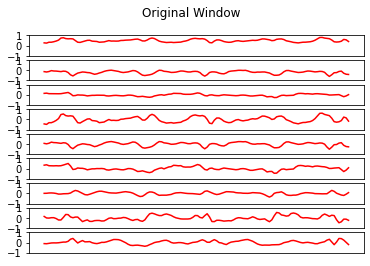

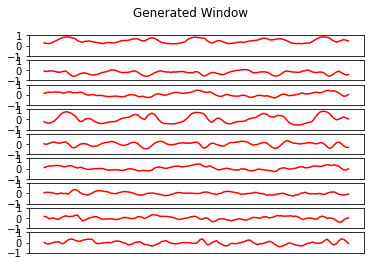

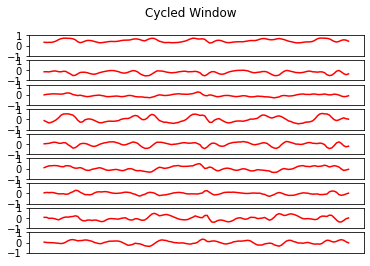

Saving checkpoint for epoch 50 at /content/gdrive/My Drive/./checkpoints/dmcyclegan/train/ckpt-11
Time taken for epoch 50 is 42.53170156478882 sec



In [0]:
fit(50)

transfer source subject to target domain and plot it

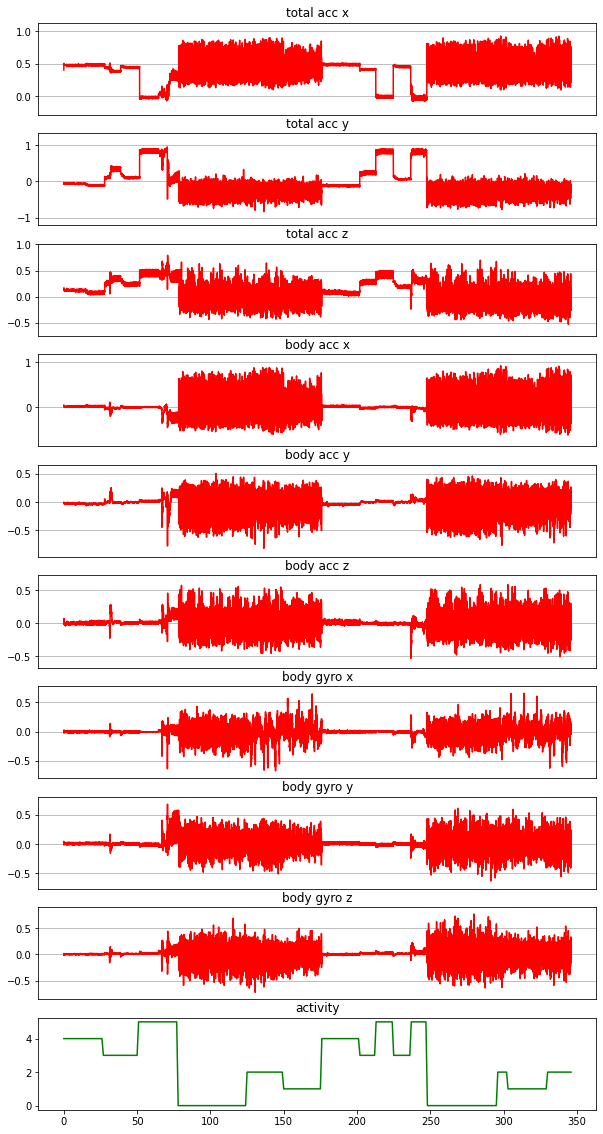

In [0]:
transfered_source_subject_X = generator_s2t(source_subject_X)
plot_subject(transfered_source_subject_X, source_subject_y)

get the accuracy after transfer

In [0]:
_, acc = subject_classifier_model.evaluate(transfered_source_subject_X, source_subject_y, batch_size=50)

7/7 [==============================] - 0s 5ms/step - loss: 1.4928 - accuracy: 0.5476
